## OFDM Signal Processing

A complete **baseband receiver-side analysis** of an OFDM signal:

* Synchronization via energy threshold and correlation
* CP detection to validate symbol structure
* FFT demodulation for symbol extraction
* Visualization of constellation and power spectrum
* Subcarrier diagnostics for quality inspection

Unkown parameters: 

- CP length
- FFT length
- Symbol start index
 - Null subcarriers


This framework is valuable for evaluating **modulation integrity**, **timing accuracy**, and **subcarrier behavior** in both simulated and real-world OFDM systems.


### 1. **Signal Preprocessing**

* Load the received signal (input data)
* Define OFDM parameters:

  * Estimated symbol length
  * Estimated cyclic prefix
  * Total symbol length

### 2. **Autocorrelation for Rough Symbol Start**

* Compute autocorrelation of the received signal to identify repeating structure.
* Detect the **initial start index** of OFDM symbols based on energy thresholding.
* Use a moving window to refine this estimate.


### 3. **Cyclic Prefix (CP) Correlation-Based Detection**

* Sweep over candidate start indices around the rough estimate.
* For each, check the correlation between CP and end of symbols.
* Select the start index that gives the **maximum average CP correlation**.


### 4. **Downsampling and Multiple Tests**

* Optionally test different values of symbol scaling or downsampling factor

* Analyze resolution and robustness across symbol lengths.


### 5. **Symbol Extraction and FFT**

* From the chosen start index, extract all OFDM symbols.
* Remove the cyclic prefix from each.
* Perform FFT on each symbol to transform to the frequency domain.
* Apply `fftshift` to center the DC subcarrier.


### 6. **Constellation Plotting**

* Flatten all subcarriers from all symbols into a single array.
* Plot real vs. imaginary values of subcarriers to visualize:

  * Identify modulation type (e.g., QPSK, QAM)
  * Analyze signal quality and distortions

### 7. **Subcarrier Power Analysis**

* Calculate power per subcarrier for each symbol.
* Identify **low-power (null or attenuated)** subcarriers.
* Use `stem` plots to highlight which subcarriers fall below a threshold (e.g., power < threshold).
* Overplot known null subcarriers for verification.


### 8. **Focused Subcarrier Constellation**

* Extract only the **useful subcarriers**
* Discard DC or null subcarriers
* Flatten and visualize constellation from these active carriers.

---

# 1. Signal Preprocessing 

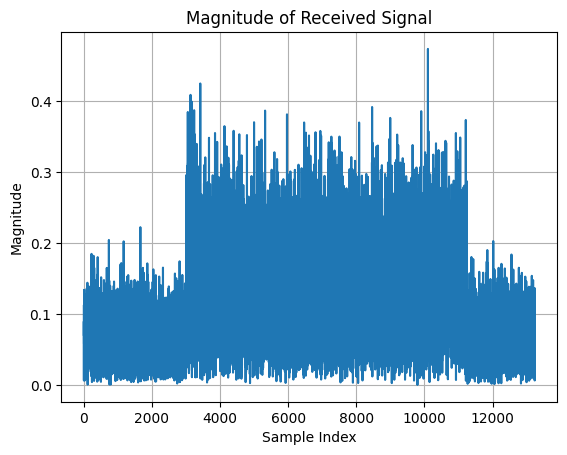

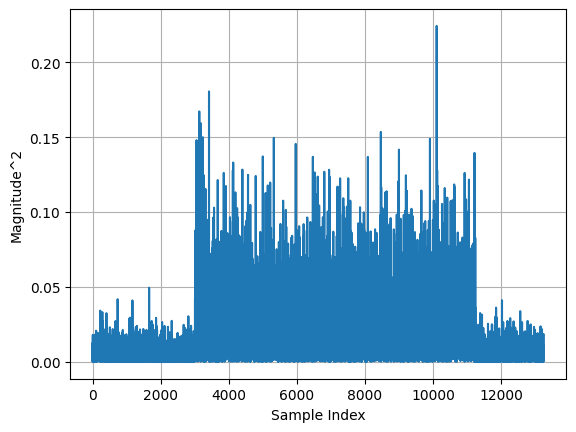

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

# Load the received signal

rx_signal = np.load('ofdm_rx_signal.npy')

# Received = scipy.io.loadmat('RxSignal.mat')
# print(Received.keys())
# rx_signal = Received['RxSignal']  
# rx_signal = rx_signal.squeeze()  # Convert (n,1) to (n,) if needed

plt.figure()
plt.plot(np.abs(rx_signal))  # Magnitude
plt.title('Magnitude of Received Signal')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.abs(rx_signal)**2)  # Magnitude
plt.xlabel('Sample Index')
plt.ylabel('Magnitude^2')
plt.grid(True)
plt.show()


## 2. Autocorrelation Analysis of Received Signal

Computing **autocorrelation** of the received signal to analyze its periodic structure and estimate symbol length.

### Autocorrelation Function

For a real-valued discrete signal $x[n]$, the autocorrelation function $R_{xx}[k]$ is defined as:

$$
R_{xx}[k] = \sum_{n} x[n] \cdot x[n+k]
$$

Where:

* $k$ is the **lag** (shift),
* For negative $k$, we evaluate $x[n] \cdot x[n - |k|]$,
* For normalization (`'coeff'`), we divide by the maximum value of $|R_{xx}[k]|$.

### Why Autocorrelation?

* Peaks in the autocorrelation function at non-zero lags can indicate **periodic patterns**.
* In digital communications, repeated symbol structures create peaks at multiples of **symbol length**.
* Here, a peak at lag = x, suggests the symbol duration is approximately **x samples**.


* Repeated peaks suggest periodicity in the received signal.
* If a peak occurs at lag ≈ x, it implies a **symbol duration** of x samples:


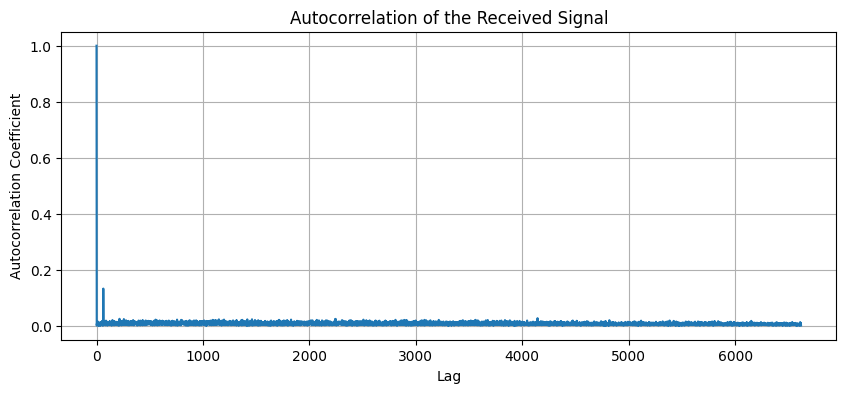

Detected peak lags: [  64  150  216  257  434  555  757  796 1093 1117 1150 1198 1316 1369
 1417 1461 1489 1715 1828 2070 2246 2508 2809 2891 3081 3216 3562 3677
 3838 4144]
Estimated Symbol Duration: 86 samples


In [27]:
from scipy.signal import find_peaks

N = len(rx_signal)
max_lag = N // 2 # floor(N/2) for considering positive lags only

# Compute autocorrelation using numpy
Rxx_full = np.correlate(rx_signal, rx_signal, mode='full')  # Full autocorrelation
lags = np.arange(-N + 1, N)
# Normalize 
Rxx_full = Rxx_full / np.max(np.abs(Rxx_full))

# Take only positive lags
mid_index = len(Rxx_full) // 2
Rxx_positive = Rxx_full[mid_index:(mid_index + max_lag + 1)]
lags_positive = lags[mid_index:(mid_index + max_lag + 1)]

plt.figure(figsize=(10, 4))
plt.plot(lags_positive, np.abs(Rxx_positive))
plt.title('Autocorrelation of the Received Signal')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.grid(True)
plt.show()

peaks, _ = find_peaks(np.abs(Rxx_positive), height=0.02, distance=20)

peak_lags = lags_positive[peaks]
print("Detected peak lags:", peak_lags)

# Only estimate if we have at least 2 peaks
if len(peak_lags) >= 2:
    symbol_duration_est = peak_lags[1] - peak_lags[0]
    print("Estimated Symbol Duration:", symbol_duration_est, "samples")
else:
    print("Not enough peaks found to estimate symbol duration.")





## Start Index Detection Based on Noise Threshold

The **start of the useful signal** in a received waveform based on power thresholding

- Estimate background noise power from the samples.
- Detect where the signal power significantly exceeds the noise.
- Mark and highlight a region around the detected start index.


### 1. Noise Power Estimation

If roughly N samples are noisy samples at the beginning of received signal, then:

$$
P_{\text{noise}} = \frac{1}{N} \sum_{n=1}^{N} |x[n]|^2
$$

Where:

- \( x[n] \) is the received signal,
- \( |x[n]| \) is the magnitude (for complex signals).

### 2. Threshold-Based Detection

We detect the **first index** where the signal power exceeds a multiple of the noise power:

$$
\text{start\_index} = \min \left\{ n : |x[n]|^2 > \text{Threshold} \cdot P_{\text{noise}} \right\}
$$



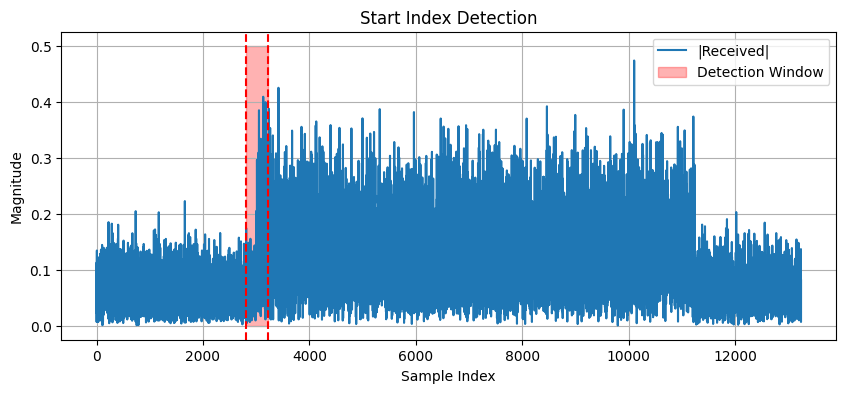

In [ ]:
noise1_power = np.mean(np.abs(rx_signal[:4000])**2) 
# 4000 is an arbitrary choice for noise estimation according the figure of received signal 
Threshold = 7 # the threshold factor is empirically chosen

# Find the start index where signal power exceeds noise threshold
ind = np.where(np.abs(rx_signal)**2 > Threshold * noise1_power)[0]
start_index = ind[0] if len(ind) > 0 else None

# Plot up to 5×start_index
plt.figure(figsize=(10, 4))
plt.plot(np.abs(rx_signal[:5*start_index]), label='|Received|')
plt.axvline(start_index - 200, color='r', linestyle='--')
plt.axvline(start_index + 200, color='r', linestyle='--')

# Shade the region from (start_index - 100) to (start_index + 100)
x_shade = [start_index - 200, start_index + 200, start_index + 200, start_index - 200]
y_shade = [0, 0, 0.5, 0.5]  # Adjust height if needed based on your signal

plt.fill(x_shade, y_shade, color='red', alpha=0.3, label='Detection Window')
plt.title("Start Index Detection")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()